In [6]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from concrete_CCQC_model import concrete_CCQC

def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc


def cost(weights, bias, X, Y):    
    predictions = []
    for x  in X:
        vqc = concrete_CCQC(data=x, weights=weights, bias=bias)
        predictions.append(vqc())
    # predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)


data = np.loadtxt("data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
Y = data[:, -1]


np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


num_qubits = 2
num_layers = 6
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    # predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_train = np.sign(concrete_CCQC(data=feats_train.T, weights=weights, bias=bias)())
    # predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))
    predictions_val = np.sign(concrete_CCQC(data=feats_val.T, weights=weights, bias=bias)())

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
            # f"weights: {weights} | bias: {bias}\n"     
        )




Iter:     2 | Cost: 1.6326220 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.1617946 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 0.9722648 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:     8 | Cost: 1.0064263 | Acc train: 0.5333333 | Acc validation: 0.4800000
Iter:    10 | Cost: 1.0260849 | Acc train: 0.5200000 | Acc validation: 0.4400000
Iter:    12 | Cost: 0.9212492 | Acc train: 0.5733333 | Acc validation: 0.5200000
Iter:    14 | Cost: 0.8735639 | Acc train: 0.7866667 | Acc validation: 0.8400000
Iter:    16 | Cost: 0.8382919 | Acc train: 0.7866667 | Acc validation: 0.7200000
Iter:    18 | Cost: 0.8026322 | Acc train: 0.6400000 | Acc validation: 0.6800000
Iter:    20 | Cost: 0.7905306 | Acc train: 0.5600000 | Acc validation: 0.5200000
Iter:    22 | Cost: 0.8172579 | Acc train: 0.5466667 | Acc validation: 0.5200000
Iter:    24 | Cost: 0.7689830 | Acc train: 0.5733333 | Acc validation: 0.5200000
Iter:    26 | Cost: 0.653384

In [7]:
np.save('weights.npy', weights)
np.save('bias.npy', bias)
print("Weights saved to 'weights.npy'")# read the weights from the file

# weights = np.load('weights.npy')
# bias = np.load('bias.npy')
# print("Weights loaded from 'weights.npy':", weights)
# print("Bias:", bias)



Weights saved to 'weights.npy'
Weights loaded from 'weights.npy': [[[ 0.00653821  0.40217313  0.01373629]
  [ 0.01887692 -0.67664941 -0.0030067 ]]

 [[-0.00455989  0.38432687 -0.00494759]
  [-0.00098711 -0.38982848  0.01300289]]

 [[ 0.00351263  0.52782828 -0.00411356]
  [-0.01072419 -0.44170588 -0.00119043]]

 [[-0.01410346  0.56786872 -0.01011447]
  [ 0.0032203  -0.18406186 -0.02039416]]

 [[ 0.00904707  0.57717888  0.01334793]
  [ 0.01071571 -0.21767476 -0.0011275 ]]

 [[-0.00579456  0.63668409  0.00472149]
  [ 0.00819917  0.0090752  -0.00585823]]]
Bias: -0.12298222500814028


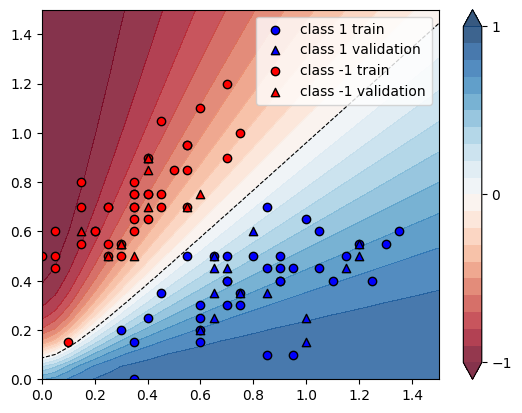

In [8]:
from matplotlib import pyplot as plt

plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = (concrete_CCQC(data=features_grid.T, weights=weights, bias=bias)())
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()